In [31]:
import openmc
import numpy as np
import time
import csv

In [20]:
#mats taken from openmc triso example https://github.com/openmc-dev/openmc/wiki/Example-Jupyter-Notebooks

#TRISO fuel specific
fuel = openmc.Material(name='Fuel')
fuel.set_density('g/cm3', 10.4)
fuel.add_nuclide('U235', 4.6716e-02)
fuel.add_nuclide('U238', 2.8697e-01)
fuel.add_nuclide('O16',  5.0000e-01)
fuel.add_element('C', 1.6667e-01)

PyC = openmc.Material(name='PyC1')
PyC.set_density('g/cm3', 1.9)
PyC.add_element('C', 1.0)
PyC.add_s_alpha_beta('c_Graphite')

#outer pebble material
graphite = openmc.Material()
graphite.set_density('g/cm3', 1.7)
graphite.add_element('C', 1.0)
graphite.add_s_alpha_beta('c_Graphite')


#PBR coolant type
he = openmc.Material(name='He')
he.set_density('atom/b-cm', 0.0006) #'atom/b-cm', 0.0006
he.add_element('He', 1.0)

#in centimeters (assuming it to be, looking at above units)
peb_or = 3
peb_ir = 2.5
kernel_or = 0.0455  #may need to look for this value & the one below
kernel_ir = 0.025
core_r = 0.5*100
core_h = 4.16*100

#so this would be needed in case we want to add more layers for our core
#reflector_t = core_r*0.3

#pebble looking at the fuel portion
peb_wfuel = openmc.Sphere(r=peb_ir)
peb_wfuel_outer = -peb_wfuel #saying that the outer radius is simply the pebble inner radius

sphere_kern = openmc.Sphere(r=kernel_ir)
cell = [openmc.Cell(fill=fuel, region = -sphere_kern), openmc.Cell(fill=PyC, region=+sphere_kern)] #the "+sphere_kern" is saying that the PyC layer 
                                                                                                   #is past the fuel-containing kernel
triso_univ = openmc.Universe(cells=cell)

centers = openmc.model.pack_spheres(kernel_or, region=peb_wfuel_outer, pf=0.1) #saying to fill only the fuel portion of the TRISO particle
#above function will pack pebbles into a sphere, it returns an array of positions that are used in the in next line of code 
trisos = [openmc.model.TRISO(kernel_or, triso_univ, center) for center in centers] # packs pebbles based on the centers positions array 
#print(centers) #this is the positions of the TRISO pebbles themselves

peb_nofuel = openmc.Sphere(r=peb_or) #generates a sphere of this radius
peb_nofuel_zone_outer = -peb_nofuel 
peb_nofuel_zone_inner = +peb_wfuel #creates a non-fuel region for our pebble
peb_fuel_zone = -peb_wfuel

sphere = openmc.Cell(region=peb_wfuel_outer) #only focusing on fuel containing portion of our fuel pebble
lower_left, upper_right = sphere.region.bounding_box
shape = (20, 20, 20) #Number of lattice elements in the x-, y-, and z-directions, look at the example in the repo
pitch = (upper_right - lower_left)/shape
lattice = openmc.model.create_triso_lattice(
    trisos, lower_left, pitch, shape, graphite)

sphere.fill = lattice

pebble_element = [sphere,
              openmc.Cell(fill=graphite, region=peb_nofuel_zone_inner & peb_nofuel_zone_outer)]
pebble_univ = openmc.Universe(cells=pebble_element)
active_core_sides = openmc.ZCylinder(r = core_r)
active_core_top = openmc.ZPlane(z0=(core_h/2))
active_core_bot = openmc.ZPlane(z0=-(core_h/2))
active_core_bound = -active_core_sides & -active_core_top & +active_core_bot

print(pitch)

[0.25 0.25 0.25]


In [71]:
results = []
new_row = []
with open("1day_run_final_positions.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
    for row in reader: # each row is a list
        results.append(row)
      
def multiply_list_by_scalar(list_of_lists, scalar):
    output = [[element * scalar for element in sub_list] for sub_list in list_of_lists]
    return output

# Example usage:
my_list = results
scalar_value = 100
multiplied_list = multiply_list_by_scalar(my_list, scalar_value)
multiplied_list[0] 

[-7.42791, -48.4345, -205.002]

In [73]:
print("starting openmc pack")
start_time = time.perf_counter()
peb_centers = multiplied_list
#openmc(peb_or, region=active_core_bound, pf = .40, contraction_rate = 0.0000001)
#need to implement this as an array of a bunch of position arrays, this might be randomly generated
print(time.perf_counter()-start_time)

pebs = [openmc.model.TRISO(peb_or, pebble_univ, peb_center) for peb_center in peb_centers] #display the locations of these pebbles using the ARFC computer
#implement our pebble locations

peb_centertest = np.vstack([peb.center for peb in pebs]) #veritically stacks the above array to easily read the positions of the pebbles
print(peb_centertest.min(axis=0))
print(peb_centertest.max(axis=0))

inner_core = openmc.Cell(region=active_core_bound)
lower_left_core, upper_right_core = inner_core.region.bounding_box
shape_core = (20, 20, 20)
pitch_core = (upper_right_core - lower_left_core)/shape_core
core_lattice = openmc.model.create_triso_lattice(
    pebs, lower_left_core, pitch_core, shape_core, he)

inner_core.fill=core_lattice

starting openmc pack
5.426400457508862e-05
[ -49.0027  -49.0037 -205.012 ]
[ 49.0021  49.0051 199.823 ]


/home/ceserz2/anaconda3/envs/lammps-openmc/lib/python3.12/site-packages/openmc/model/triso.py:850: UserWarning: TRISO particle is partially or completely outside of the lattice.
  warnings.warn('TRISO particle is partially or completely '


[  0.46772565 -20.73890916 -63.07428842] [ -44.81278196  -14.17090586 -132.96788961]


In [4]:
#AGAIN, looking at adding material surrounding the core (or our cask)

#outer_reflector_sides = openmc.ZCylinder(r = (core_r+reflector_t), boundary_type='vacuum')
#outer_reflector_top = openmc.ZPlane(z0=((core_h/2)+reflector_t),boundary_type='vacuum')
#outer_reflector_bot = openmc.ZPlane(z0=-((core_h/2)+reflector_t),boundary_type='vacuum')
#reflector_outer = -outer_reflector_sides & -outer_reflector_top & +outer_reflector_bot
#reflector_bounds = reflector_outer | active_core_bound
#reflector = openmc.Cell(region = reflector_bounds, fill = graphite)

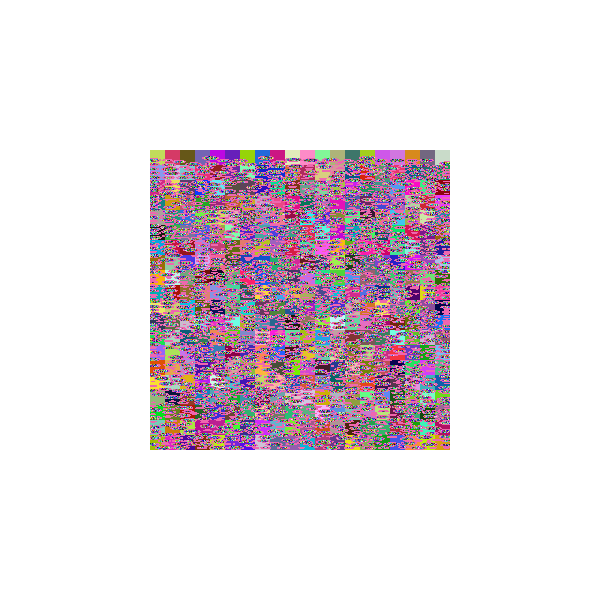

In [75]:
universe = openmc.Universe(cells=[inner_core])

geometry = openmc.Geometry(universe)
geometry.export_to_xml()

materials = list(geometry.get_all_materials().values())
openmc.Materials(materials).export_to_xml()

settings = openmc.Settings()
settings.run_mode = 'plot'
settings.export_to_xml()

#mc.plot_geometry()
plot = openmc.Plot.from_geometry(geometry)
plot.basis = 'xz'
plot.width = (core_r*4, core_h*2)
plot.pixels = (600, 600)
plot.to_ipython_image()
#mc.plot_inline(plot)

In [49]:
plot.color_by = 'material'
plot.colors = {graphite: 'gray', he: 'lightblue', fuel: 'hotpink', PyC: 'lavender'}
plot.width = (core_r*3, core_h*1.5)
plot.pixels = (2400, 2400)
plot.to_ipython_image()

KeyboardInterrupt: 